### Agenda / points covered in the PoC


 This relates to reoccurring complaints about automobiles that visit the repair facility frequently owing to the same sort of problem.
 
We have data from the Dealers management system that includes the following data points. <br>
•	Vehicle Identification Number <br>
•	Service centre visit times and dates  <br>
•	Client complaint, for which the car is taken to the service centre  <br>
•	Complainant's job card information  <br>
•	The action done by the service centre to resolve the issue  <br>
### Problems that must be solved  <br>
•	Customer verbatim is same as the Dealer understanding  <br>
•	Action taken is same as Customer verbatim  <br>
•	Classification of customer verbatim eg - classification on the basis of noise  <br>
•	Identification of major categories  <br>
•	Same vehicle with similar problem which indicates the problem was not resolved in the first time - 2 months  <br>
•	Recommendation on the correctness of Action taken  <br>
•	Detect automobiles that have frequent and comparable faults that are submitted to the service centre.  <br>
•	Classify the problem that requires the vehicle to be repaired regularly.  <br>
•	Recognize the patterns shown below.  <br>
•	Vehicle type  <br>
•	Service component with repeated failures  <br>
•	Whether the dealer's response addressed and handled the problem  <br>
•	Whether the issue was clearly understood by the service centre   <br>
•	Whether any specific part is frequently failing and highlighting the same for RCA and long-term fixing of the same  <br>
•	Find and predict patterns in the car models / batches where similar issue is likely to occur in the future and suggest / highlight probable actions regarding the same <br>


In [188]:
# Import Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from difflib import SequenceMatcher
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV
from textblob import TextBlob  # For sentiment analysis (install it if not already installed)
from sklearn.feature_extraction.text import TfidfVectorizer  # For text analysis
from datetime import timedelta
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# import category_encoders as ce

#### Understanding the data and Preperation

In [181]:
# Load data from csv file
vehicle_data = pd.read_csv("Repeat order1.csv")
vehicle_data1= pd.read_csv("vehicle_data.csv")
vehicle_data2=pd.read_csv("Repeat_oder2.csv")
vehicle_data.head()
vehicle_data1.head()
vehicle_data2.head()

,Dealer Zone,Area Office,Dealer Name,Dealer Code,Location,RO Number,Immobilised,Bill Period,MFG Period,Chassis Bo,Varient Description,Model Family Cd,Description,category,RO STATUS,Service type Running Repair,Service category Repair,SV_RO_HDR_SK,Customer Verbatim,Verbatim Source,Verbatim Closing Status,Observation,Service Advisor,Action Taken by taken,Verbatim Code,Verbatim Source.1,RO_DATE
0,East Zone,Bhubaneshwar,ADITYA MOTORS,SA011351,CUTTACK,RO23A002570,N,FY-2023 Jun,2022-Jan,B6A12165,AX7 D MT,J17,Diesel,MT,Billed,ACCIDENTAL,Bodyshop,64106254,ACCIDENTAL REPAIR AS PER ESTIMATE,Customer,Attended,ACCIDENTAL REPAIR AS PER ESTIMATE,MANOJ PATRA,ACCIDENTAL REPAIR AS PER ESTIMATE,BOD1004,C,12/5/2022
1,East Zone,Bhubaneshwar,ADITYA MOTORS,SA011351,CUTTACK,RO23A002570,N,FY-2023 Jun,2022-Jan,B6A12165,AX7 D MT,J17,Diesel,MT,Billed,ACCIDENTAL,Bodyshop,64106254,WASHING & CLEANING,System,Attended,WASHING & CLEANING,MANOJ PATRA,WASHING & CLEANING,BOD1004,Y,12/5/2022
2,East Zone,Bhubaneshwar,ADITYA MOTORS,SA011351,CUTTACK,RO23A003501,N,FY-2023 May,2022-May,B6E16583,AX5 D MT,J17,Diesel,MT,Billed,PDI SERVICE,Pre-Sale/PDI,64317300,PDI SERVICE,Customer,Attended,PDI SERVICE,SAROJ KUMAR SAHOO,PDI SERVICE DONE,GEN1003,C,26-05-2022
3,East Zone,Bhubaneshwar,ADITYA MOTORS,SA011351,CUTTACK,RO23A003310,N,FY-2023 May,2021-Dec,M6M13070,AX7 P MT,J19,Gasoline,MT,Billed,1ST FREE SERVICE,Free Service,64274426,1000KM 1ST FREE SCHEDULE SERVICE,Customer,Attended,1000KM 1ST FREE SCHEDULE SERVICE,SATYAJEET SAMAL,1000KM 1ST FREE SCHEDULE SERVICE DONE,GEN1003,C,24-05-2022
4,East Zone,Bhubaneshwar,ADITYA MOTORS,SA011351,CUTTACK,RO23A003310,N,FY-2023 May,2021-Dec,M6M13070,AX7 P MT,J19,Gasoline,MT,Billed,1ST FREE SERVICE,Free Service,64274426,EMS ECU FLASHING,Customer,Attended,EMS ECU FLASHING,SATYAJEET SAMAL,EMS ECU FLASHING DONE,GEN1029,C,24-05-2022


In [182]:
#vehicle_data.info()
#vehicle_data1.info()
#vehicle_data2.info()
df=vehicle_data
df1=vehicle_data1
df2=vehicle_data2

### Distribution of problem statements in to Verbatim code Description

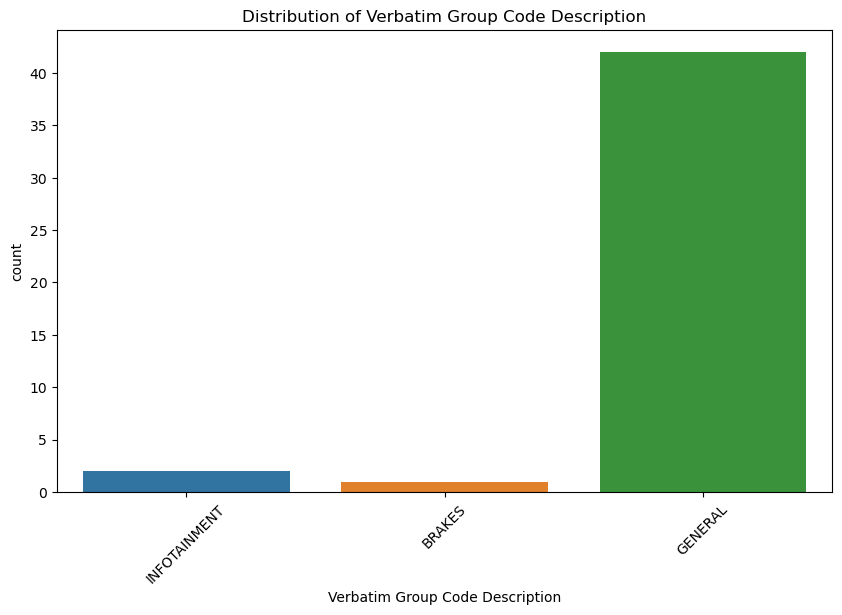

In [131]:
# Plot a bar chart for 'Verbatim Group Code Description'
plt.figure(figsize=(10, 6))
sns.countplot(data=df1, x='Verbatim Group Code Description')
plt.xticks(rotation=45)
plt.title('Distribution of Verbatim Group Code Description')
# Annotate the bars with percentage values
total = len(df1)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height() + 0.5
    ax.annotate(percentage, (x, y), fontsize=12)
plt.show()

### Calculate similarity between Observation and Action Taken

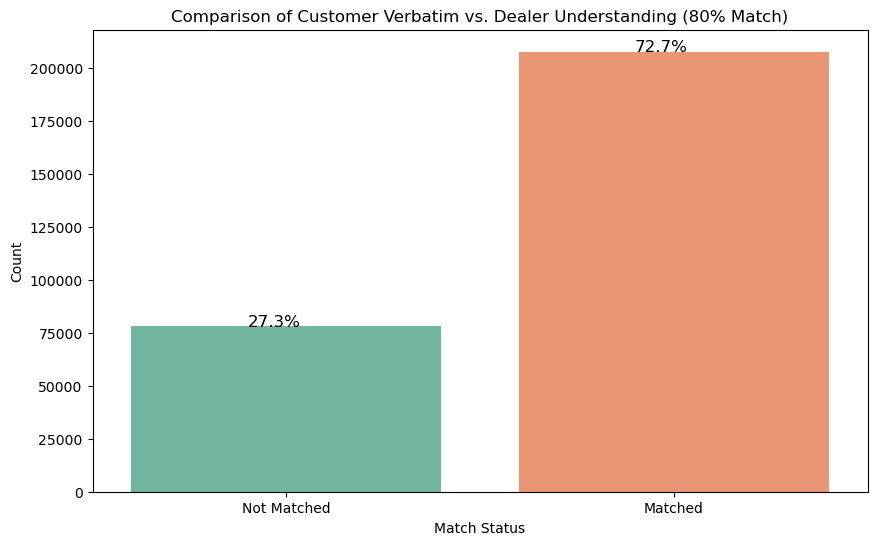

In [134]:
# Calculate similarity between Customer Verbatim and Action Taken
def calculate_similarity(row):
    similarity = SequenceMatcher(None, str(row['Customer Verbatim']), str(row['Action Taken by taken'])).ratio()
    return similarity >= 0.8  # Consider a match if similarity is >= 0.8

df['Match'] = df.apply(calculate_similarity, axis=1)

# Create a count plot to compare Customer Verbatim vs. Dealer Understanding
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='Match', palette='Set2')
plt.xticks([0, 1], ['Not Matched', 'Matched'])
plt.xlabel('Match Status')
plt.ylabel('Count')
plt.title('Comparison of Customer Verbatim vs. Dealer Understanding (80% Match)')

# Annotate the bars with percentage values
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height() + 0.5
    ax.annotate(percentage, (x, y), fontsize=12)

plt.show()


### Approach to improve the "Matched" data in the above chart to improve the dealer understanding of the customer verbatim


In [206]:
# use NLP
# Load historical data with Verbatim Code and Verbatim text
historical_data = pd.read_csv('historical_data.csv')

# Load new customer verbatims data
new_data = pd.read_csv('new_customer_data1.csv')

# Remove rows with missing (NaN) values in 'Customer Verbatim' column
new_data = new_data.dropna(subset=['Customer Verbatim'])

# Split the historical data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    historical_data['Customer Verbatim'],
    historical_data['Verbatim Code'],
    test_size=0.2,
    random_state=42
)

# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train a simple text classification model (e.g., Multinomial Naive Bayes)
classifier = MultinomialNB()
classifier.fit(X_train_vectorized, y_train)

# Remove rows with missing (NaN) values in 'Customer Verbatim' column in new_data
new_data = new_data.dropna(subset=['Customer Verbatim'])

# Vectorize the new customer verbatims using the same CountVectorizer instance
new_data_vectorized = vectorizer.transform(new_data['Customer Verbatim'])

# Predict Verbatim Codes for the new customer verbatims
predicted_codes = classifier.predict(new_data_vectorized)

# Add the predicted Verbatim Codes to the new_data DataFrame
new_data['Predicted Verbatim Code'] = predicted_codes

# Save the results to a CSV file
new_data.to_csv('categorized_verbatims.csv', index=False)

# Evaluate the model's accuracy on the test data (optional)
y_pred = classifier.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on the test data: {accuracy:.2f}')
#print(classification_report(y_test, y_pred))

Accuracy on the test data: 0.68


### Classification of Customer verbatim (eg - classification on the basis of keywords)

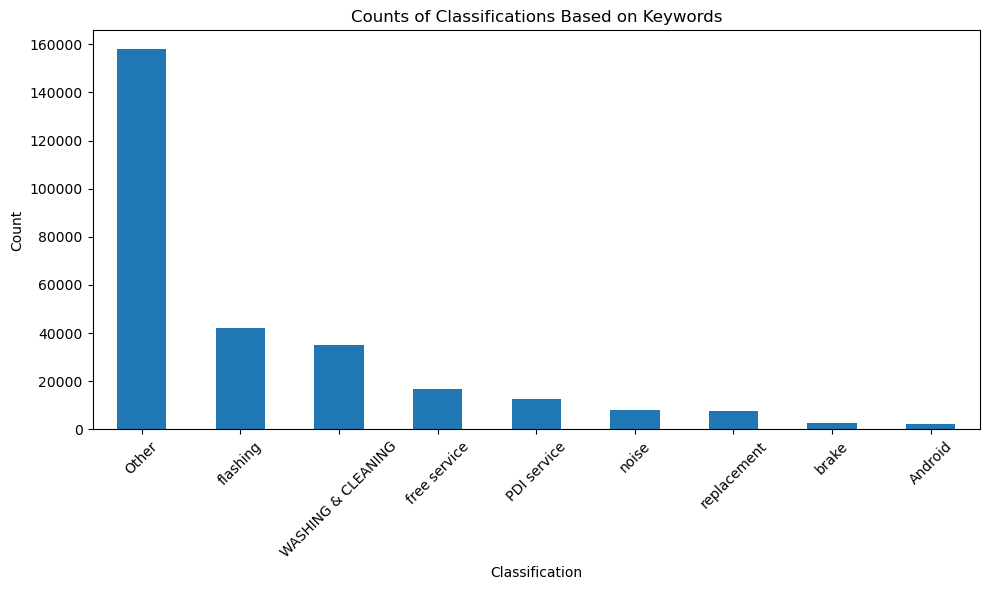

In [137]:
# Define a list of keywords
keywords = ['WASHING & CLEANING', 'free service', 'brake', 'replacement' , 'Android', 'flashing' , 'PDI service' , 'noise']

# Define a function to classify based on keywords
def classify_verbatim(row, keywords):
    if pd.isna(row['Observation']) or pd.isna(row['Action Taken by taken']):
        return 'Missing'
    
    for keyword in keywords:
        if keyword.lower() in row['Observation'].lower() or keyword.lower() in row['Action Taken by taken'].lower():
            return keyword
    
    return 'Other'

# Apply the classification function to create a new column 'Classification'
df['Classification'] = df.apply(classify_verbatim, args=(keywords,), axis=1)

# Filter out rows with 'Missing' in the 'Classification' column
filtered_df = df[df['Classification'] != 'Missing']

# Display only 'Verbatim Group Code Description,' 'Model Name,' and 'Classification' columns
result_df = filtered_df[['Verbatim Code', 'Varient Description', 'Classification']]
result_df.columns = ["Verbatism Description", "Family Description", "Classification"]  # Rename the columns as needed
#print(result_df.head(20))

# Count the occurrences of each classification
classification_counts = filtered_df['Classification'].value_counts()

# Plot the results
plt.figure(figsize=(10, 6))  
classification_counts.plot(kind='bar')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.title('Counts of Classifications Based on Keywords')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()



### Same vehicle service more than once with the same Verbatim Group Code within 2 months period


In [207]:
# Convert 'RO_DATE' to datetime
df2['RO_DATE'] = pd.to_datetime(df2['RO_DATE'])

# Function to find repeated vehicles within 2 months
def find_repeated_vehicles(df2):
    repeated_vehicles = []
    
    for index, row in df2.iterrows():
        vehicle_code = row['Chassis Bo']
        Verbatim_Code = row['Verbatim Code']
        ro_date = row['RO_DATE']
        
        # Filter the DataFrame for the same vehicle and Verbatim Group Code within 2 months
        mask = (df2['Chassis Bo'] == vehicle_code) & (df2['Verbatim Code'] == Verbatim_Code) & \
               (df2['RO_DATE'] >= ro_date - timedelta(days=60)) & (df2['RO_DATE'] < ro_date)
        
        if len(df2[mask]) > 1:
            repeated_vehicles.append(vehicle_code)
    
    return repeated_vehicles

# Call the function to find repeated vehicles
repeated_vehicles = find_repeated_vehicles(df2)

# Save the results to a CSV file
new_data.to_csv('vehicles_repeated_issues.csv', index=False)

print("Repeated issues data saved in to csv")

Repeated issues data saved in to csv


### Analysis of the repeated issues for the same vehicles in 2 months period

   Chassis Bo Verbatim Code
1    B6A12165       BOD1004
4    M6M13070       GEN1029
5    M6M13070       GEN1032
6    M6M13070       GEN1032
7    M6M13070       GEN1029
8    M6M13070       GEN1029
9    M6M13070       GEN1007
12   B6A11647       GEN1032
14   B6B16163       BOD1004
17   B6A12263       GEN1008
18   B6A12263       GEN1007
20   M6M13800       GEN1016
21   M6M13800       GEN1032
22   M6M13800       GEN1033
23   M6M13800       GEN1007
25   M6M13703       BOD1004
27   B6C16800       GEN1007
29   M6M14056       GEN1029
30   M6M14056       GEN1029
31   M6M14056       GEN1007


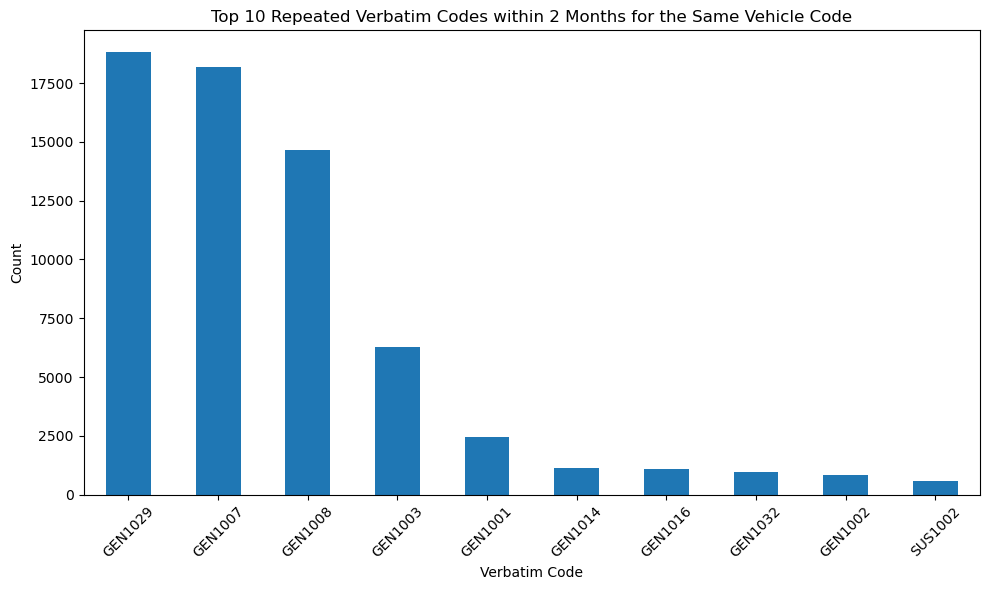

In [156]:
# Convert 'Service Date' to datetime format
df2['RO_DATE'] = pd.to_datetime(df2['RO_DATE'])

# Create a dictionary to store the previous service date for each vehicle
previous_service_date = {}

# Function to check if a vehicle had a previous service within 2 months
def has_previous_service(row):
    vehicle_code = row['Chassis Bo']
    service_date = row['RO_DATE']
    
    if vehicle_code in previous_service_date:
        prev_date = previous_service_date[vehicle_code]
        if service_date - prev_date <= timedelta(days=60):
            return True
    
    previous_service_date[vehicle_code] = service_date
    return False

# Apply the function to check for repeated services
df2['Repeated Service'] = df2.apply(has_previous_service, axis=1)

# Filter the DataFrame to include only repeated services
repeated_services_df = df2[df2['Repeated Service']]

# Display the result with vehicle code and verbatim code
result_df = repeated_services_df[['Chassis Bo', 'Verbatim Code']]
print(result_df.head(n=20))

# Group by 'Verbatim Code' and count the occurrences
verbatim_counts = repeated_services_df['Verbatim Code'].value_counts()

# Plot the result
# Get the top 10 repeated Verbatim Codes
top_10_verbatim_counts = verbatim_counts.head(10)

# Plot the result
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
top_10_verbatim_counts.plot(kind='bar')
plt.xlabel('Verbatim Code')
plt.ylabel('Count')
plt.title('Top 10 Repeated issues for the same vehicles in 2 months period')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


###  Detect vehicle types that have frequent and comparable faults that are submitted to the service centre.

In [183]:
# Count the frequency of each Family Description-Verbatim combination
verbatim_counts = df2.groupby(['Varient Description', 'Customer Verbatim']).size().reset_index(name='Frequency')

# Find the most frequent Family Description for each Verbatim
most_frequent_family = verbatim_counts.groupby('Customer Verbatim')['Varient Description'].agg(lambda x: x.mode().iloc[0])

# Count the frequency of the most frequent Family Description
family_counts = most_frequent_family.value_counts().reset_index()
family_counts.columns = ['Varient Description', 'Frequency']

# Define a threshold for comparing frequencies
threshold = 2  # Adjust this threshold as needed

# Filter Family Descriptions with comparable frequencies
comparable_families = family_counts[family_counts['Frequency'] >= threshold]

# Display Family Descriptions with comparable frequencies
print("Varient Description with Frequent and Comparable Customer Verbatim:")
print(comparable_families)

#graph



Varient Description with Frequent and Comparable Customer Verbatim:
     Varient Description  Frequency
0             AX7 L D AT       3043
1               AX5 D MT       3013
2               AX5 P MT       2397
3               AX7 D MT       1992
4             AX7 L P AT       1881
5             AX7 L D MT       1604
6               AX7 P MT       1467
7               AX5 D AT       1282
8               AX7 D AT       1127
9               AX7 P AT       1119
10        AX7 L D AT AWD       1008
11               MX D MT        951
12         AX7 L D AT C2        621
13               MX P MT        595
14              AX5 P AT        592
15              AX3 D MT        546
16              AX3 P MT        273
17           AX7 D AT C2        253
18         AX7 L P AT C2        236
19           AX5 D AT C2        217
20     AX7 L D AT AWD C2        145
21          AX7 D AT AWD        141
22              AX3 D AT        131
23            AX7 T D MT        116
24           AX7 P AT C2        

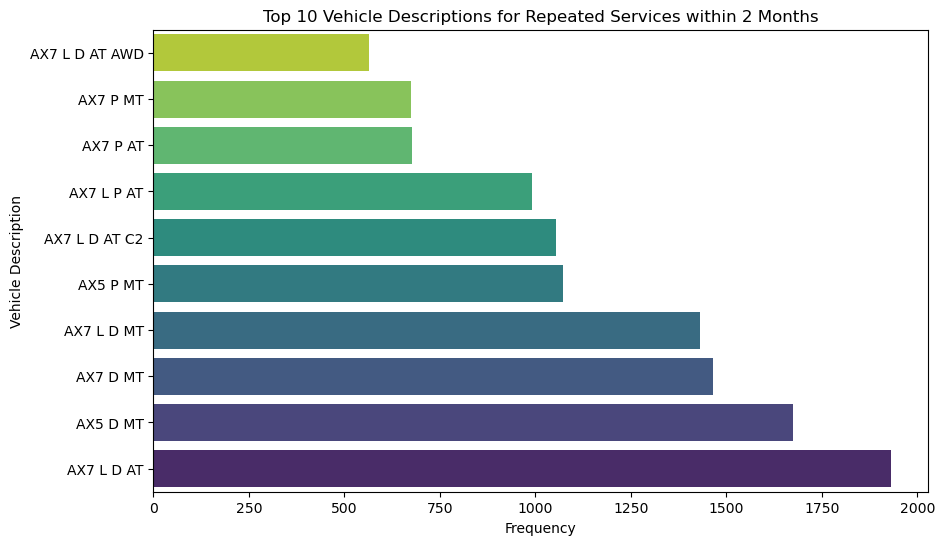

In [187]:
#graph
# Filter the DataFrame for services within 2 months
df['RO_DATE'] = pd.to_datetime(df['RO_DATE'])  # Convert 'RO_DATE' to datetime if not already
two_months_ago = pd.to_datetime('today') - pd.DateOffset(months=2)
filtered_df = df[df['RO_DATE'] >= two_months_ago]

# Group the data by 'Vehicle Description' and count occurrences
vehicle_counts = filtered_df['Varient Description'].value_counts().head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=vehicle_counts.values, y=vehicle_counts.index, palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Vehicle Description')
plt.title('Top 10 Vehicle models for Repeated Services within 2 Months')
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest frequency at the top
plt.show()

In [196]:
# Load your historical data with columns: 'Chassis Bo', 'Verbatim Code', 'RO_DATE'
data = pd.read_csv('historical_data.csv')

# Convert 'RO_DATE' to datetime objects
data['RO_DATE'] = pd.to_datetime(data['RO_DATE'])

# Sort the data by 'Chassis Bo' and 'RO_DATE'
data.sort_values(by=['Chassis Bo', 'RO_DATE'], inplace=True)

# Define a function to check if verbatim codes are repeated within a time frame
def mark_future_issues(group):
    # Calculate the time difference within which verbatim codes are considered repeated
    time_threshold = timedelta(days=60)  # Adjust as needed
    
    # Check for repeated verbatim codes
    group['FutureIssue'] = 0
    for i in range(1, len(group)):
        if group['Verbatim Code'].iloc[i] == group['Verbatim Code'].iloc[i - 1] and \
           group['RO_DATE'].iloc[i] - group['RO_DATE'].iloc[i - 1] <= time_threshold:
            group.at[group.index[i], 'FutureIssue'] = 1
    return group

# Apply the function to each group of 'Chassis Bo'
data_with_future_issue = data.groupby('Chassis Bo').apply(mark_future_issues)

# Save the modified data to a new CSV file or use it for further analysis
data_with_future_issue.to_csv('data_with_future_issue.csv', index=False)

### Predicted Top 10 future issues

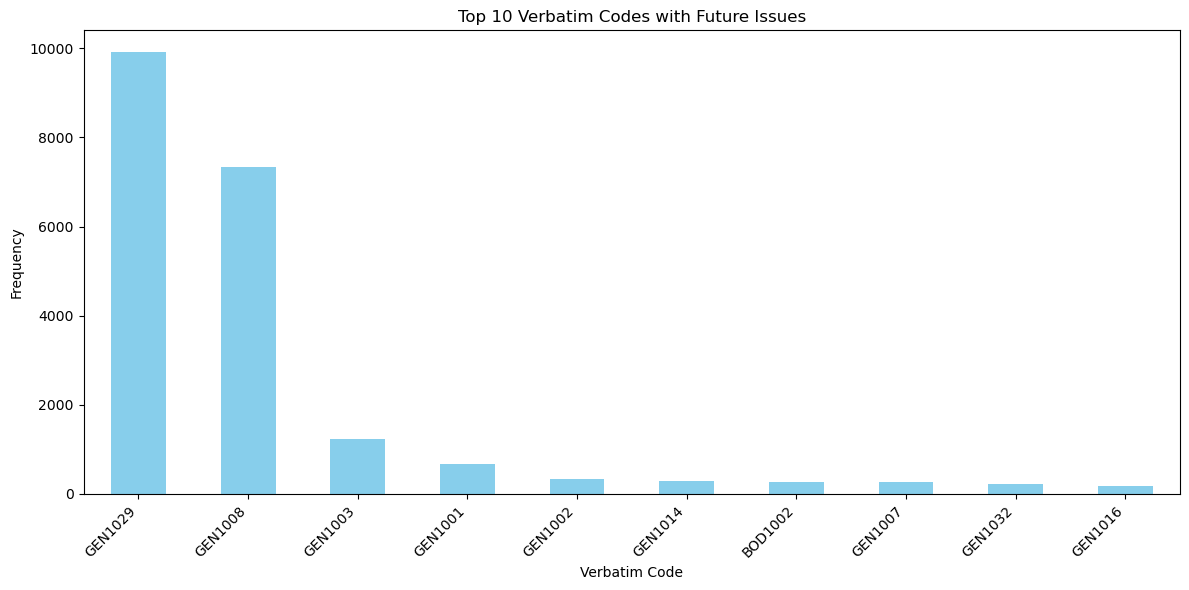

In [198]:
#plot the graph  to show which verbatim codes that will have futureIssue =1

# Load the data with 'FutureIssue' column
data_with_future_issue = pd.read_csv('data_with_future_issue.csv')

# Filter the data to include only rows where 'FutureIssue' is 1
future_issue_data = data_with_future_issue[data_with_future_issue['FutureIssue'] == 1]

# Count the occurrences of each verbatim code with future issues
verbatim_code_counts = future_issue_data['Verbatim Code'].value_counts()

# Select the top 10 verbatim codes with future issues
top_10_verbatim_codes = verbatim_code_counts.head(10)

# Plot a bar chart to visualize the top 10 verbatim codes with future issues
plt.figure(figsize=(12, 6))
top_10_verbatim_codes.plot(kind='bar', color='skyblue')
plt.title('Top 10 Verbatim Codes with Future Issues')
plt.xlabel('Verbatim Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

### Top 10 vehicle models that will have frequent future issues

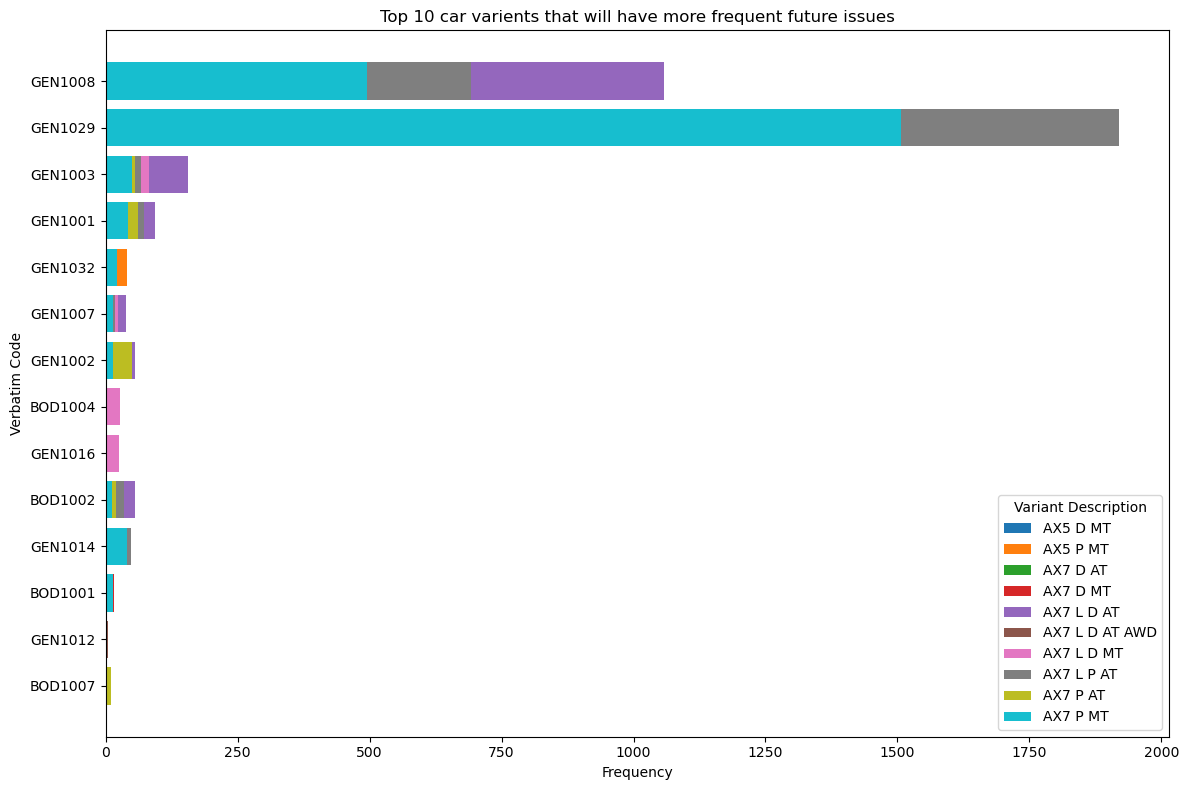

In [204]:
# Load the data with 'FutureIssue' column
data_with_future_issue = pd.read_csv('data_with_future_issue.csv')

# Filter the data to include only rows where 'FutureIssue' is 1
future_issue_data = data_with_future_issue[data_with_future_issue['FutureIssue'] == 1]

# Calculate the frequency of each 'Varient Description'
variant_description_counts = future_issue_data['Varient Description'].value_counts()

# Select the top 10 'Varient Description' based on frequency
top_10_variant_descriptions = variant_description_counts.head(10).index

# Filter the data to include only the top 10 'Varient Description'
filtered_data = future_issue_data[future_issue_data['Varient Description'].isin(top_10_variant_descriptions)]

# Group the data by 'Varient Description' and 'Verbatim Code' and count the occurrences
grouped_data = filtered_data.groupby(['Varient Description', 'Verbatim Code']).size().reset_index(name='Frequency')

# Sort the data by 'Frequency' in descending order within each 'Varient Description' group
grouped_data = grouped_data.sort_values(['Varient Description', 'Frequency'], ascending=[True, False])

# Get the top 10 'Verbatim Code' for each 'Varient Description'
top_10_per_variant = grouped_data.groupby('Varient Description').head(10)

# Plot a bar chart for each 'Varient Description'
plt.figure(figsize=(12, 8))
for variant_description, data in top_10_per_variant.groupby('Varient Description'):
    plt.barh(data['Verbatim Code'], data['Frequency'], label=variant_description)

plt.title('Top 10 car varients that will have more frequent future issues')
plt.xlabel('Frequency')
plt.ylabel('Verbatim Code')
plt.legend(title='Variant Description')
plt.gca().invert_yaxis()  # Invert the y-axis to display the top verbatim code at the top
plt.tight_layout()
plt.show()